<a href="https://colab.research.google.com/github/arshupadhyaya/Thesis_Poster/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array,save_img
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
# Mount the drive
drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


In [ ]:
class Dataloader:
    def __init__(self, img_folder, mask_folder, IMG_WIDTH=64, IMG_HEIGHT=64, split=0.8):
        self.IMG_WIDTH = IMG_WIDTH
        self.IMG_HEIGHT = IMG_HEIGHT
        self.img_folder = img_folder
        self.mask_folder = mask_folder
        self.split = split

    def load_image_path(self):
        input_img_paths = sorted(
            [os.path.join(self.img_folder, fname) for fname in os.listdir(self.img_folder) if fname.endswith(".jpg")]
        )
        target_img_paths = sorted(
            [os.path.join(self.mask_folder, fname) for fname in os.listdir(self.mask_folder) if fname.endswith(".png")]
        )
        return input_img_paths, target_img_paths

    def process_image(self, img_paths, mask_paths, noise_level=0):
        X = np.zeros((len(img_paths), self.IMG_WIDTH, self.IMG_HEIGHT, 3), dtype=np.float32)
        Y = np.zeros((len(mask_paths), self.IMG_WIDTH, self.IMG_HEIGHT, 1), dtype=np.float32)

        for i in range(len(img_paths)):
            img = img_paths[i]
            img = load_img(img, color_mode="rgb", target_size=(self.IMG_WIDTH, self.IMG_HEIGHT))
            img = img_to_array(img)
            if noise_level > 0:
                noise = np.random.normal(0, noise_level, img.shape)
                img = np.clip(img + noise, 0, 255)
            X[i] = img.astype('float32') / 255.0

            mask = mask_paths[i]
            mask = load_img(mask, color_mode="grayscale", target_size=(self.IMG_WIDTH, self.IMG_HEIGHT))
            mask = img_to_array(mask)
            Y[i] = mask.astype('float32') / 255
        return X, Y

    def save_datasets(self, X, Y, img_paths, mask_paths, noise_level, base_folder):
        noise_folder = os.path.join(base_folder, f'noise_{int(noise_level * 100)}')
        img_folder = os.path.join(noise_folder, 'images')
        mask_folder = os.path.join(noise_folder, 'masks')
        os.makedirs(img_folder, exist_ok=True)
        os.makedirs(mask_folder, exist_ok=True)

        for i in range(X.shape[0]):
            original_img_name = os.path.basename(img_paths[i])
            original_mask_name = os.path.basename(mask_paths[i])
            img_path = os.path.join(img_folder, original_img_name)
            mask_path = os.path.join(mask_folder, original_mask_name)
            save_img(img_path, X[i])
            save_img(mask_path, Y[i])
        print(f'Saved dataset with noise level {noise_level:.2f} to {noise_folder}')

    def get_data_with_noise_levels(self, base_folder):
        img_paths, mask_paths = self.load_image_path()
        noise_levels = np.arange(0, 0.5, 0.05)
        datasets = []
        for noise_level in noise_levels:
            X, Y = self.process_image(img_paths, mask_paths, noise_level)
            self.save_datasets(X, Y, img_paths, mask_paths, noise_level, base_folder)
            datasets.append((X, Y, noise_level))
        return datasets

In [ ]:
# Example usage:
img_folder = '/content/drive/My Drive/Unet_Dataset/train'
mask_folder = '/content/drive/My Drive/Unet_Dataset/train_mask'
dataloader = Dataloader(img_folder, mask_folder)


In [ ]:
base_save_folder = '/content/drive/My Drive/Unet_augmented'

In [ ]:
datasets = dataloader.get_data_with_noise_levels(base_save_folder)

Saved dataset with noise level 0.00 to /content/drive/My Drive/Unet_augmented/noise_0
Saved dataset with noise level 0.05 to /content/drive/My Drive/Unet_augmented/noise_5
Saved dataset with noise level 0.10 to /content/drive/My Drive/Unet_augmented/noise_10
Saved dataset with noise level 0.15 to /content/drive/My Drive/Unet_augmented/noise_15
Saved dataset with noise level 0.20 to /content/drive/My Drive/Unet_augmented/noise_20
Saved dataset with noise level 0.25 to /content/drive/My Drive/Unet_augmented/noise_25
Saved dataset with noise level 0.30 to /content/drive/My Drive/Unet_augmented/noise_30
Saved dataset with noise level 0.35 to /content/drive/My Drive/Unet_augmented/noise_35
Saved dataset with noise level 0.40 to /content/drive/My Drive/Unet_augmented/noise_40
Saved dataset with noise level 0.45 to /content/drive/My Drive/Unet_augmented/noise_45


In [ ]:
len('/content/drive/MyDrive/Unet_Dataset_augmented/noise_0/images')

60

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras.optimizers import Adam
import tensorflow.keras.backend as K

def simple_Unet(input_size=(64, 64, 3)):
    inputs = Input(input_size)

    # Contracting Path
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)

    # Expanding Path
    up4 = UpSampling2D(size=(2, 2))(conv3)
    up4 = Conv2D(64, 2, activation='relu', padding='same')(up4)
    merge4 = concatenate([conv2, up4], axis=3)
    conv4 = Conv2D(64, 3, activation='relu', padding='same')(merge4)
    conv4 = Conv2D(64, 3, activation='relu', padding='same')(conv4)

    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = Conv2D(32, 2, activation='relu', padding='same')(up5)
    merge5 = concatenate([conv1, up5], axis=3)
    conv5 = Conv2D(32, 3, activation='relu', padding='same')(merge5)
    conv5 = Conv2D(32, 3, activation='relu', padding='same')(conv5)

    # Output
    outputs = Conv2D(1, 1, activation='sigmoid')(conv5)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model
    model.summary()

def diceCoefficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)

def diceLoss(y_true, y_pred):
    return 1 - diceCoefficient(y_true, y_pred)


In [ ]:
# Create the model
model = Unet()

# Print the model summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 64, 64, 64)           1792      ['input_3[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 64)           256       ['conv2d_26[0][0]']           
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 64, 64, 64)           0         ['batch_normalization[0]

In [ ]:
from keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, Conv2DTranspose, Concatenate
from keras.layers import Input, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Conv2DTranspose

import tensorflow as tf

def Unet():
    inputs = Input((64, 64, 3))  # Update input size to 64x64

    """ Encoder """
    s1, x1 = contraction(inputs, 64)
    s2, x2 = contraction(x1, 128)
    s3, x3 = contraction(x2, 256)
    s4, x4 = contraction(x3, 512)

    """ Bridge """
    x5 = conv_block(x4, 1024)

    """ Decoder """
    x6 = expansion(x5, s4, 512)
    x7 = expansion(x6, s3, 256)
    x8 = expansion(x7, s2, 128)
    x9 = expansion(x8, s1, 64)

    """ Outputs """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(x9)

    """ Model """
    model = Model(inputs, outputs)
    return model

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

# Downsample the resolution of the images
def contraction(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

# Upsample the resolution of the images, but decrease the feature maps
def expansion(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from keras.optimizers import SGD
from mpl_toolkits.mplot3d import Axes3D

# Initialize storage for losses
losses = []

# Define the paths for the datasets
base_path = '/content/drive/My Drive/Unet_augmented'

# List of noise levels
noise_levels = ['noise_0', 'noise_05', 'noise_10', 'noise_15', 'noise_20', 'noise_25', 'noise_30', 'noise_35', 'noise_40', 'noise_45']

# Training parameters
batch_size = 15
epochs = 20

# Iterate over each noise level dataset
for noise_level in noise_levels:
    # Adjust the path for noise_05 to handle the special case
    if noise_level == 'noise_05':
        noise_folder = 'noise_5'
    else:
        noise_folder = noise_level

    # Load the data
    img_folder = f'{base_path}/{noise_folder}/images'
    mask_folder = f'{base_path}/{noise_folder}/masks'

    dataloader = Dataloader(img_folder, mask_folder, IMG_WIDTH=64, IMG_HEIGHT=64)
    X, Y = dataloader.process_image(*dataloader.load_image_path())

    # Initialize and compile the model
    model = Unet()
    model.compile(optimizer=SGD(), loss=diceLoss, metrics=["accuracy", diceCoefficient])

    # Train the model and store the loss values for each epoch
    noise_loss_values = []
    for epoch in range(epochs):
        history = model.fit(X, Y, batch_size=batch_size, epochs=1, verbose=1)
        noise_loss_values.append(history.history['loss'][0])

    # Store the loss values and corresponding noise level
    losses.append((noise_loss_values, noise_level))

60/60 [==============================] - 5s 81ms/step - loss: 0.1427 - accuracy: 0.9331 - diceCoefficient: 0.8573


Text(0.5, 0.92, 'Training Loss over Different Noise Levels and Epochs')

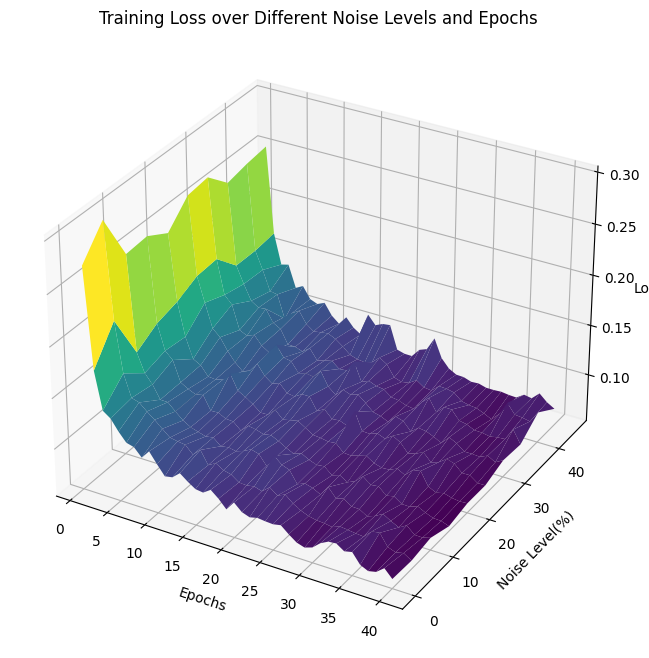

In [ ]:
noise_levels_int = [int(noise.split('_')[1]) for _, noise in losses]
iterations = np.arange(1, epochs + 1)
loss_values = np.array([loss for loss, _ in losses])

# Plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a meshgrid for the noise levels and iterations
X, Y = np.meshgrid(noise_levels_int, iterations)
Z = loss_values.T

# Plot the surface
ax.plot_surface(Y,X, Z, cmap='viridis')

# Labels and title
ax.set_xlabel('Epochs')
ax.set_ylabel('Noise Level(%)')
ax.set_zlabel('Loss')
ax.set_title('Training Loss over Different Noise Levels and Epochs')


Text(0.5, 0.92, 'Training Loss over Different Noise Levels and Epochs')

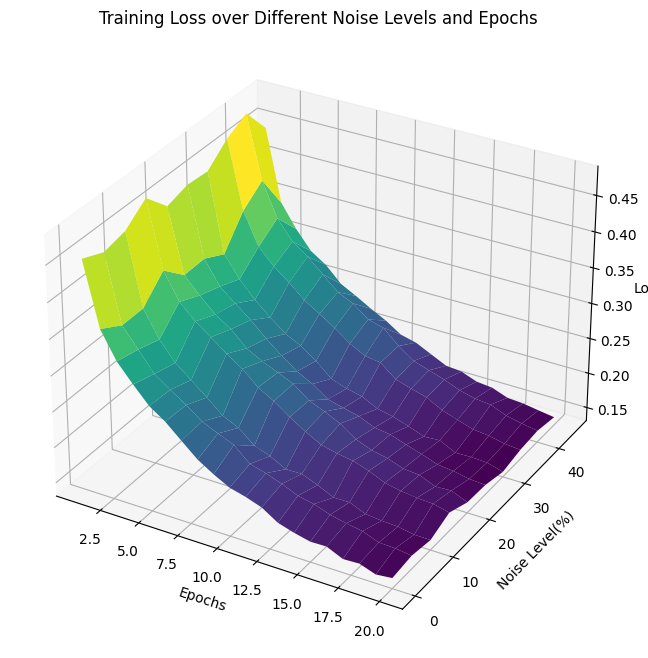

In [ ]:
noise_levels_int = [int(noise.split('_')[1]) for _, noise in losses]
iterations = np.arange(1, epochs + 1)
loss_values = np.array([loss for loss, _ in losses])

# Plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a meshgrid for the noise levels and iterations
X, Y = np.meshgrid(noise_levels_int, iterations)
Z = loss_values.T

# Plot the surface
ax.plot_surface(Y,X, Z, cmap='viridis')

# Labels and title
ax.set_xlabel('Epochs')
ax.set_ylabel('Noise Level(%)')
ax.set_zlabel('Loss')
ax.set_title('Training Loss over Different Noise Levels and Epochs')


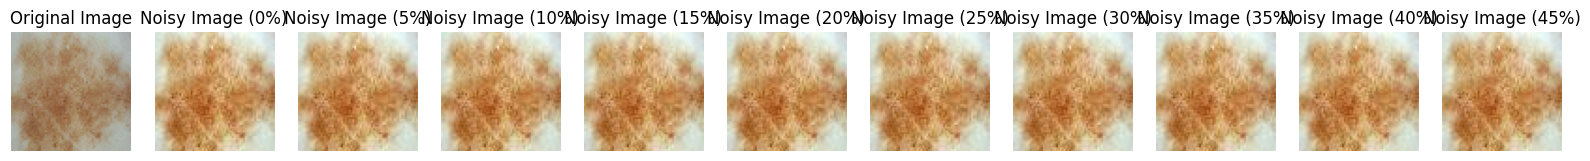

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
import os

# Define the noise levels
noise_levels = ['noise_0', 'noise_05', 'noise_10', 'noise_15', 'noise_20', 'noise_25', 'noise_30', 'noise_35', 'noise_40', 'noise_45']

# Load the original image for comparison
img_folder = '/content/drive/My Drive/Unet_Dataset/train'
original_img_path = os.path.join(img_folder, 'ISIC_0009995.jpg')
original_img = img_to_array(load_img(original_img_path, target_size=(64, 64))) / 255.0

# Plot the original image
fig, axs = plt.subplots(1, len(noise_levels) + 1, figsize=(20, 6))
axs[0].imshow(original_img)
axs[0].set_title("Original Image")
axs[0].axis('off')

# Plot the noisy images
for i, noise_level in enumerate(noise_levels):
    # Adjust the path for noise_05 to handle the special case
    if noise_level == 'noise_05':
        noise_folder = 'noise_5'
    else:
        noise_folder = noise_level

    noisy_img_folder = f'/content/drive/My Drive/Unet_Dataset_augmented/{noise_folder}/images'
    noisy_img_path = os.path.join(noisy_img_folder, 'ISIC_0009995.jpg')
    noisy_img = img_to_array(load_img(noisy_img_path, target_size=(64, 64))) / 255.0

    axs[i + 1].imshow(noisy_img)
    axs[i + 1].set_title(f"Noisy Image ({int(noise_level.split('_')[1])}%)")
    axs[i + 1].axis('off')

plt.show()


In [ ]:
import os

# Define the folder path
folder_path = '/content/drive/MyDrive/Unet_Dataset_augmented/noise_0/images'

# Get a list of files in the folder
files = os.listdir(folder_path)

# Count the number of files
num_files = len(files)

print(f'There are {num_files} files in the folder: {folder_path}')


There are 900 files in the folder: /content/drive/MyDrive/Unet_Dataset_augmented/noise_0/images


In [ ]:
import os

# Define the paths to the folders
images_folder = '/content/drive/MyDrive/Unet_Dataset_augmented/noise_0/images'
masks_folder = '/content/drive/MyDrive/Unet_Dataset_augmented/noise_0/masks'

# Get the list of files in the images folder
image_files = os.listdir(images_folder)

# Get the list of files in the masks folder
mask_files = os.listdir(masks_folder)

# Delete the second set of 900 files
for file in image_files[900:]:
    os.remove(os.path.join(images_folder, file))

for file in mask_files[900:]:
    os.remove(os.path.join(masks_folder, file))

print("Second set of 900 files deleted successfully.")

Second set of 900 files deleted successfully.


In [ ]:
import os

# Define the paths to the folders
images_folder = '/content/drive/MyDrive/Unet_Dataset_augmented/noise_0/images'
masks_folder = '/content/drive/MyDrive/Unet_Dataset_augmented/noise_0/masks'

# Function to delete all files inside a folder
def delete_all_files(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            # Uncomment the line below if you also want to delete subdirectories
            # elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")

# Delete all files inside the images folder
delete_all_files(images_folder)

# Delete all files inside the masks folder
delete_all_files(masks_folder)
